In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, ebf
import numpy as np, pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import NullFormatter
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

In [2]:
folder = '/home/andy/Documents/Research/SF/SFdata/Galaxia_data/'
iso_folder = '/home/andy/Documents/Research/SF/SFdata/'

In [113]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import StatisticalModels as sm

# Running selection function

In [9]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import SelectionGrid, IsochroneScaling

In [5]:
from seestar import SelectionGrid, IsochroneScaling

## Generate selection function from scratch

We have prebuilt the 3 component GMM selection functions so only use gen_obsSF() if you wish to rebuild (takes about 20' on 3 cores).

gen_intSF() takes less than a minute so this is fine.

In [187]:
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
survey['Colour'] = survey.Japp-survey.Kapp

pointings = pd.read_csv(folder + '/Galaxia_sf_fieldinfo.csv')
pointings = pointings[['fieldID', 'glon', 'glat', 'halfangle','Magmin', 'Magmax', 'Colmin', 'Colmax']]
pointings.rename({'glon':'phi', 'glat':'theta'})

def get_spectro(field):
    
    field_data = survey[survey.fieldID==field]
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

def get_photo(field):
    
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

In [188]:
pointings = pointings[1:]

In [104]:
pointings.Magmin = 'NoLimit'
pointings.Magmax = 'NoLimit'
pointings.Colmin = 'NoLimit'

In [290]:
SF = SelectionGrid.SFGenerator(get_spectro, get_photo, pointings, 
                              spectro_model=('BGM_TNC', None), photo_model=('BGM_TNC', None))

The spectro model description is:('BGM_TNC', None)
The photo model description is:('BGM_TNC', None)


## Generate new selection functions

In [11]:
%%time
# Load in the isochrone interpolant
IsoCalculator = IsochroneScaling.IntrinsicToObservable()
IsoCalculator.LoadColMag(iso_folder+'isochrones/isochrone_interpolantinstances.pickle')

CPU times: user 5.84 s, sys: 1.3 s, total: 7.14 s
Wall time: 7.17 s


In [291]:
%%time
SF.gen_obsSF(folder+'/Galaxia_obsSF.pickle')

Creating colour-magnitude field interpolants...
Finished col-mag calculation: 2.0, 1/2, Time: 0.00m, Left: 0.00m('N stars = ', 4501)
Running BGM
(2, '...', -43744.71154093469)
(3, '...', -44502.66851326439)
(4, '...', -45133.49896501862)
(5, '...', -45566.94820707787)
(6, '...', -45765.42821586185)
(7, '...', -45791.980428609255)
(8, '...', -45852.38407191596)
(9, '...', -45881.78827755957)
(10, '...', -45882.80150482471)
(11, '...', -45870.596998927875)
(12, '...', -45824.3958017704)
('Best components: ', 10)
('Param shape: ', (10, 6))

('N stars = ', 294)
('Prior boundaries: ', array([[-4.28693339,  1.80879233],
       [-3.12050678,  5.36044332]]))
(True, 'Converged (|f_n-f_(n-1)| ~= 0)')
(2, '...', 1875.896950852504, '...', 903.8469968222199)
(True, 'Converged (|f_n-f_(n-1)| ~= 0)')
(3, '...', 1930.958752258525, '...', 914.3271582232144)
(False, 'Linear search failed')
(4, '...', 1981.1219637648974, '...', 922.3580246743845)
(True, 'Converged (|f_n-f_(n-1)| ~= 0)')
(5, '...', 2034.3

In [49]:
spectro_points = get_spectro(field)
spectro_points = pd.DataFrame(np.array(spectro_points), columns=['appMag', 'Colour'])

photo_points = get_photo(field)
photo_points = pd.DataFrame(np.array(photo_points), columns=['appMag', 'Colour'])

In [55]:
fieldpointing = pointings.loc[2.0]

In [57]:
cm_limits=None

In [58]:
prior_sfBounds = np.zeros((2,2))

# Use given limits to determine boundaries of dataset
# apparent mag upper bound
if fieldpointing.Magmin == "NoLimit":
    if cm_limits is None: mag_min = np.min(spectro_points.appMag) - 1
    else: mag_min = cm_limits[0]
    prior_sfBounds[1,0] = np.min(photo_points.appMag)
else:
    mag_min = fieldpointing.Magmin - 1
    prior_sfBounds[1,0] = mag_min
# apparent mag lower bound
if fieldpointing.Magmax == "NoLimit":
    if cm_limits is None: mag_max = np.max(spectro_points.appMag) + 1
    else: mag_max = cm_limits[1]
    prior_sfBounds[1,1] = np.max(photo_points.appMag)
else:
    mag_max = fieldpointing.Magmax + 1
    prior_sfBounds[1,1] = mag_max
# colour uppper bound
if fieldpointing.Colmin == "NoLimit":
    if cm_limits is None: col_min = np.min(spectro_points.Colour) - 0.1
    else: col_min = cm_limits[2]
    prior_sfBounds[0,0] = np.min(photo_points.Colour)
else:
    col_min = fieldpointing.Colmin - 0.1
    prior_sfBounds[0,0] = col_min
# colour lower bound
if fieldpointing.Colmax == "NoLimit":
    if cm_limits is None: col_max = np.max(spectro_points.Colour) + 0.1
    else: col_max = cm_limits[3]
    prior_sfBounds[0,1] = np.max(photo_points.Colour)
else:
    col_max = fieldpointing.Colmax + 0.1
    prior_sfBounds[0,1] = col_max

In [59]:
prior_sfBounds

array([[ 0.4       ,  1.14853718],
       [ 7.        , 14.5       ]])

In [60]:
col_min, col_max, mag_min, mag_max

(0.4, 0.8938370499811702, 7.0, 14.5)

In [ ]:
mu, std = np.mean(X)

In [ ]:
prior_sfBounds[0,:] = (prior_sfBounds[0,:]-self.mux)/self.sx
prior_sfBounds[1,:] = (prior_sfBounds[1,:]-self.muy)/self.sy

In [61]:
prior_sfBounds[:,0]

array([0.4, 7. ])

In [16]:
%%time
SF.gen_intSF(folder+'/Galaxia_intSF.pickle', IsoCalculator)

Creating distance-age-metallicity interpolants...
...done.

Overwrite /home/andy/Documents/Research/SF/SFdata/Galaxia_data//Galaxia_intSF.pickle? (y/n)n
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.96 s


In [292]:
instsf = SF.obsSF[3.0].SF_model
instdf = SF.obsSF[3.0].DF_model

In [293]:
import StatisticalModels

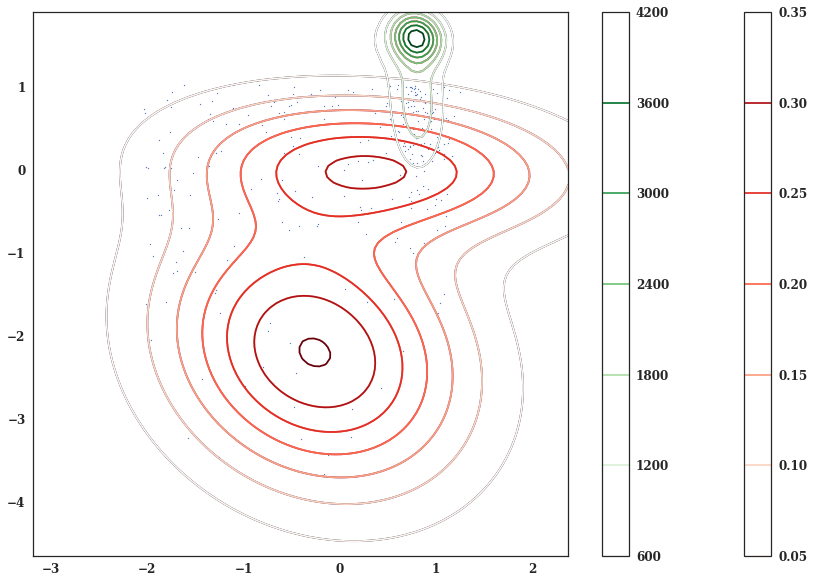

In [294]:
plt.figure(figsize=(15,10))

plt.scatter(instsf.y_s, instsf.x_s, s=1)
#plt.scatter(instsf.x_s, instsf.y_s, s=0.1)

#instsf.params_f = instsf.unscaleParams(instsf.params_f_scaled)

x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)

all_pars = instsf.params_f_scaled
zz = StatisticalModels.bivGaussMixture(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds')
plt.colorbar()

all_pars = instsf.params_df
zz = StatisticalModels.bivGaussMixture(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Greens')
plt.colorbar()

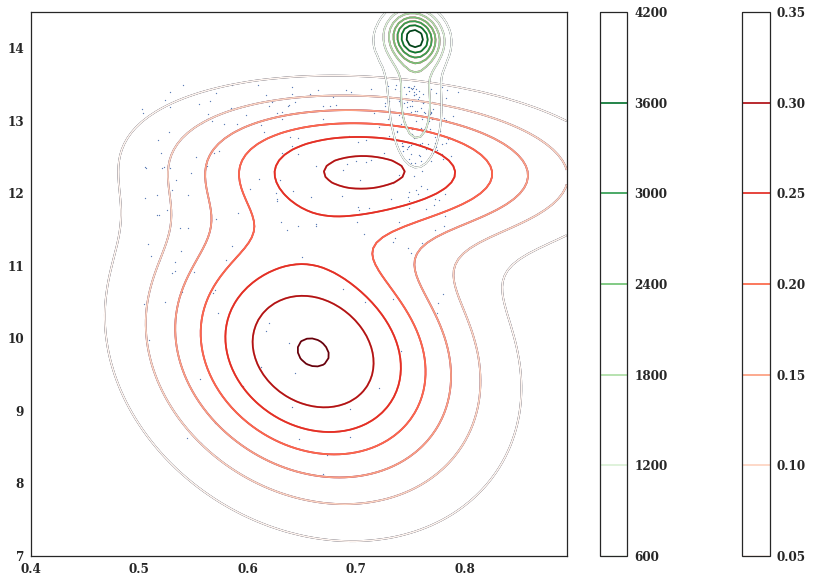

In [295]:
plt.figure(figsize=(15,10))

plt.scatter(instsf.y, instsf.x, s=1)
#plt.scatter(instsf.x_s, instsf.y_s, s=0.1)

#instsf.params_f = instsf.unscaleParams(instsf.params_f_scaled)

x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)

all_pars = instsf.params_f
zz = StatisticalModels.bivGaussMixture(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds')
plt.colorbar()

all_pars = instdf.params_f
zz = StatisticalModels.bivGaussMixture(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Greens')
plt.colorbar()

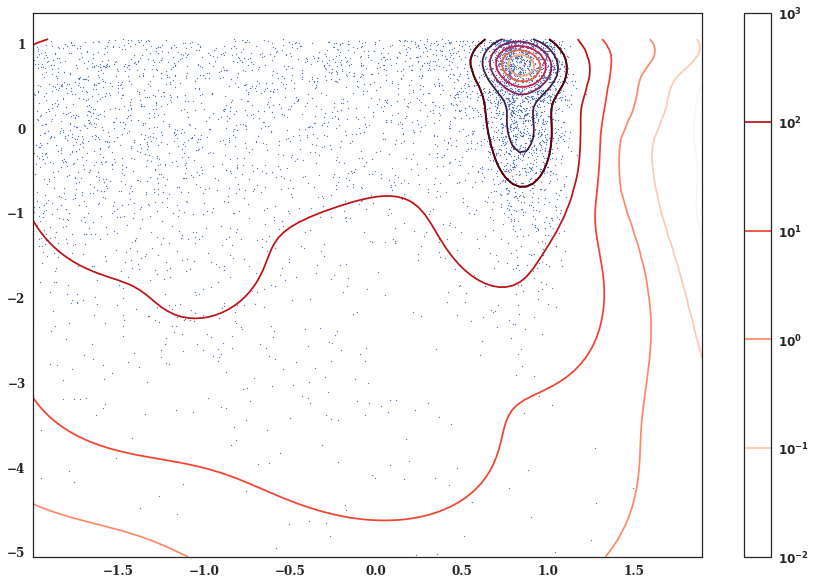

In [263]:
plt.figure(figsize=(15,10))

plt.scatter(instdf.y_s, instdf.x_s, s=1)
#plt.scatter(instdf.x_s, instdf.y_s, s=0.1)

#instdf.params_f = instdf.unscaleParams(instdf.params_f_scaled)

x = np.linspace(instdf.rngy_s[0], instdf.rngy_s[1], 100)
y = np.linspace(instdf.rngx_s[0], instdf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)

all_pars = instdf.params_f_scaled
zz = StatisticalModels.bivGaussMixture(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds', norm=LogNorm())
plt.colorbar()

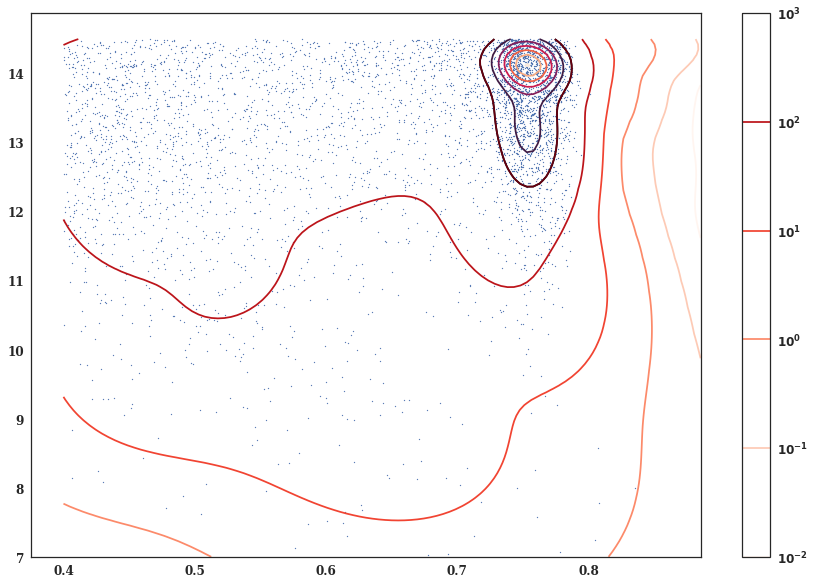

In [264]:
plt.figure(figsize=(15,10))

plt.scatter(instdf.y, instdf.x, s=1)
#plt.scatter(instdf.x_s, instdf.y_s, s=0.1)

#instdf.params_f = instdf.unscaleParams(instdf.params_f_scaled)

x = np.linspace(instdf.rngy[0], instdf.rngy[1], 100)
y = np.linspace(instdf.rngx[0], instdf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)

all_pars = instdf.params_f
zz = StatisticalModels.bivGaussMixture(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds', norm=LogNorm())
plt.colorbar()

In [283]:
phot2 = pd.read_csv('/home/andy/Documents/Research/data/asfe2/Projects/sf_data/Galaxia_data/photometric/2.0.csv')
x = phot2.Happ
y = phot2.Japp-phot2.Kapp
xs = (x-instsf.mux)/instsf.sx
ys = (y-instsf.muy)/instsf.sy

sf_params = instsf.params_f_scaled.copy()
pSelect = sm.bivGaussMixture(sf_params, xs, ys)
np.sum(pSelect), len(instsf.x), np.sqrt(np.sum(pSelect))

(313.31084166088056, 300, 17.7005887376912)

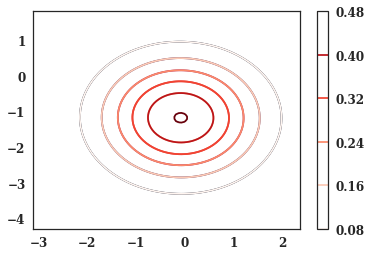

In [276]:
_x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
_y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(_x, _y)

all_pars = instsf.params_f_scaled
zz = StatisticalModels.bivGaussMixture(sf_params, yy, xx)
plt.contour(_x, _y, zz)
plt.contour(_x, _y, zz, cmap='Reds')
plt.colorbar()

In [284]:
sf_params[:,[0,1]] = sf_params[:,[0,1]] * np.array([instsf.sx, instsf.sy]) +  [instsf.mux, instsf.muy]
sf_params[:,[2,3]] *= np.array([instsf.sx**2, instsf.sy**2])
sf_params[:,5] *= (instsf.sx*instsf.sy)
pSelect = sm.bivGaussMixture(sf_params, x, y)
np.sum(pSelect), len(instsf.x), np.sqrt(np.sum(pSelect))

(313.31084166088056, 300, 17.7005887376912)

In [285]:
pSelect = sm.bivGaussMixture(instsf.params_f, x, y)
np.sum(pSelect), len(instsf.x), np.sqrt(np.sum(pSelect))

(313.31084166088056, 300, 17.7005887376912)

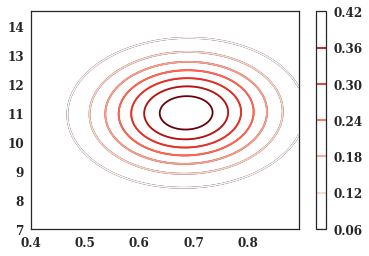

In [286]:
_x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
_y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(_x, _y)

all_pars = instsf.params_f_scaled
zz = sm.bivGaussMixture(sf_params, yy, xx)
plt.contour(_x, _y, zz)
plt.contour(_x, _y, zz, cmap='Reds')
plt.colorbar()

## Load in premade selection function

In [55]:
%%time
# Load observable selection function
SF.load_obsSF(folder+'Galaxia_obsSFemcee.pickle')
#SF.load_obsSF(folder+'/Galaxia_obsSF.pickle')

Unpickling colour-magnitude interpolant dictionaries...
...done.

CPU times: user 36 ms, sys: 104 ms, total: 140 ms
Wall time: 259 ms


In [10]:
# Load intrinsic selection function
SF.load_intSF(folder+'/Galaxia_intSF.pickle')

Unpickling intrinsic selection function...
...done.



## MCMC around local optima

Again, MCMC runs have been done previously so if you used SF.load_obsSF(), they will already exist.
If not, the emcee run for 2000 iterations takes ~2h

In [11]:
from seestar import SFInstanceClasses
import pickle
from copy import deepcopy

In [14]:
%%time
for field in list(SF.pointings.fieldID):
    inst = SF.obsSF[field].SF_model
    inst.runningL=True
    inst.optimizeParams(method='emceeBall', init='reset')

init,  reset
initial parameters [[-4.17838255  0.60042245  4.00045082  5.57702447  0.0159517   0.61505256]
 [ 0.15729628 -0.91743333  0.5005584   2.41079562  1.35527681  0.05615077]
 [ 0.49339597  0.76811856  0.1773772   4.41562592  2.47808452  0.06247564]]
itern: 1, logL: 15222.70, sum log(f(xi)): 18316.26, integral: 3093.56                
Initparam likelihood: 15222.70
itern: 0, logL: 15222.70, sum log(f(xi)): 18316.26, integral: 3093.56                \nInit  lnl:  -15222.700901748309 \n
emcee with 2000 iterations...
itern: 46384, logL: 15232.18, sum log(f(xi)): 18300.52, integral: 3068.34                
itern: 46386, logL: 15236.38, sum log(f(xi)): 18359.82, integral: 3123.44                
 emceeBall: lnprob=15236, time=3211
init,  reset
initial parameters [[ -2.68706967  -0.38594158   1.04282587   7.92005862   1.29764421
    5.38147109]
 [  0.38211516  -1.9875036    0.25763134  18.03415267   0.26860365
    1.77964795]
 [  0.38211516  -1.9875036    0.25763136 111.19048091   1.6

In [15]:
inst = deepcopy(SF.obsSF)
obsSF_path = folder+'/Galaxia_obsSFemceee.pickle'
obsSF_dicts = SFInstanceClasses.obsSF_classtodict(inst)

for field in list(SF.pointings.fieldID):
    delattr(obsSF_dicts[field]['SF_model']['output'], 'lnprobfn')
    
with open(obsSF_path, 'wb') as handle:
    pickle.dump(obsSF_dicts, handle, protocol=2)

# Load data files

In [26]:
# Load in spectroscopic data
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
# Calculate colour and magnitude of spectroscopic data
survey['Colour'], survey['Happ'] = IsoCalculator.ColourMapp(survey.ageGyr, survey.mh, survey.mass, survey.s)

# Separate spectroscopic data into field 1 and field 2, 3 overlapping
survey1 = survey[survey.fieldID == 1.0]
survey23 = survey[survey.fieldID.apply(lambda x: x in [2.0,3.0])]

In [17]:
s1 = get_spectro(1.0)

In [13]:
# Load in field 1 photometric data
full1 = pd.read_csv(folder+'/photometric/'+str(1.0)+'.csv')
full1['Colour'] = full1['Japp']-full1['Kapp']
full1.rename(index=str, columns={'feh':'mh', 'smass':'mass','rad':'s'}, inplace=True)
full1['Colour'], full1['Happ'] = IsoCalculator.ColourMapp(full1.ageGyr, full1.mh, full1.mass, full1.s)

In [24]:
# Load in field 2, 3 photometric data

full23 = pd.DataFrame()
fields= [2.0,3.0]
for field in fields:
    full23 = pd.concat((full23, pd.read_csv(folder+'/photometric/'+str(field)+'.csv')))
full23['Colour'] = full23['Japp']-full23['Kapp']
full23.rename(index=str, columns={'feh':'mh', 'smass':'mass','rad':'s'}, inplace=True)
# Recalculate to make colour and apparent magnitude agree
full23['Colour'], full23['Happ'] = IsoCalculator.ColourMapp(full23.ageGyr, full23.mh, full23.mass, full23.s)

In [27]:
survey23 = survey23.drop_duplicates(subset=['glon','glat'], keep='first', inplace=False)
full23 = full23.drop_duplicates(subset=['glon','glat'], keep='first', inplace=False)

# Calculate SF probabilities

In [61]:
# Percentile threshold
s1_prob = 31.73*0.01
# Number of samples
Ns = 25

## Field 1
- For calculating probabilities you can use the union calculation (which takes longer for large datasets and is memory intensive.
- Or if you know that the fields are not overlapping you can calculate direct from the obsSF instances.
- For field 1 we'll demonstrate both.

In [17]:
field=1.0
# Get burnt chain
sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()
# Take random set of samples within the 68.37 percentile (1sigma)
prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]
posterior_samples = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1,3,6)
# Get highest probability parameters
index = np.unravel_index(np.argmax(sampler.lnprobability), sampler.lnprobability.shape)
best = sampler.chain[index].reshape(-1,3,6)[0].copy()

In [18]:
%%time
# Generate observable coord sample from union calculation
instance = SF.obsSF[field].SF_model
params_f = instance.params_f.copy()
# Condition that stars lie within cm boundaries
con_bound = (full1.Happ>SF.obsSF[field].SF_magrange[0])&(full1.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full1.Colour>SF.obsSF[field].SF_colrange[0])&(full1.Colour<SF.obsSF[field].SF_colrange[1])

instance.params_f = instance.unscaleParams(best)
full1['union_f'] = \
    SF(full1, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
full1['union_f'][~con_bound] = 0.
instance.params_f = params_f

Calculating all SF values...
...Assigning: 2160082/2160082        
Calculating: 2160082/2160082        ...done
Calculating union contribution...
...done
CPU times: user 1min 42s, sys: 2.69 s, total: 1min 44s
Wall time: 1min 47s


/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
%%time
# Generate posterior coord samples straight from obsSF
for i in range(Ns):
    
    rand_pars = posterior_samples[i].copy()
    instance.params_f = instance.unscaleParams(rand_pars)
    
    full1['union_%d'%i] = instance(full1.Happ, full1.Colour)
    
    full1['union_%d'%i][~con_bound] = 0.
    
instance.params_f = params_f

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


CPU times: user 33.6 s, sys: 11.1 s, total: 44.7 s
Wall time: 43.5 s


In [45]:
%%time
# Generate intrinsic coord sample from union calculation
full1['union_int_f'] = \
    SF(full1, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
full1['union_int_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 2160082/2160082        
Calculating: 2160082/2160082        ...done
Calculating union contribution...
...done


/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: cannot reindex from a duplicate axis

In [ ]:
# Generate posterior intrinsic coord samples straigh from intSF
for i in range(Ns):
    
    rand_pars = posterior_samples[i].copy()
    instance.params_f = instance.unscaleParams(rand_pars)
    
    full1['union_int_%d'%i] = SF.instanceSF((full1.ageGyr, full1.mh, full1.mass, full1.s), SF.obsSF[field])
    
    full1['union_int_%d'%i][~con_bound] = 0.
    
instance.params_f = params_f

# Field 2 & 3

In [64]:
field = 2.0

shp = SF.obsSF[field].SF_model.output.chain.shape[:2] + (SF.obsSF[2.0].SF_model.nComponents,) + (-1,)
chain = SF.obsSF[field].SF_model.output.chain.reshape(shp)
flatchain = SF.obsSF[field].SF_model.output.flatchain


sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()

prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]

posterior2 = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1, 3, 6)

AttributeError: BGM_TNC instance has no attribute 'output'

In [21]:
field = 3.0

shp = SF.obsSF[field].SF_model.output.chain.shape[:2] + (SF.obsSF[2.0].SF_model.nComponents,) + (-1,)
chain = SF.obsSF[field].SF_model.output.chain.reshape(shp)
flatchain = SF.obsSF[field].SF_model.output.flatchain

sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()

prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]

posterior3 = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1, 3, 6)

In [22]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model
params_f2 = instance2.params_f.copy()
params_f3 = instance3.params_f.copy()

con_bound = (full23.Happ>SF.obsSF[field].SF_magrange[0])&(full23.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full23.Colour>SF.obsSF[field].SF_colrange[0])&(full23.Colour<SF.obsSF[field].SF_colrange[1])

for i in range(Ns):
    
    rand_pars2 = posterior2[i].copy()
    instance2.params_f = instance2.unscaleParams(rand_pars2)
    rand_pars3 = posterior3[i].copy()
    instance3.params_f = instance3.unscaleParams(rand_pars3)
    
    full23['union_%d'%i] = \
        SF(full23, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
    full23['union_%d'%i][~con_bound] = 0.
    
instance2.params_f = params_f2
instance3.params_f = params_f3
full23['union_f'] = \
        SF(full23, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()



Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 1062

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model
params_f2 = instance2.params_f.copy()
params_f3 = instance3.params_f.copy()

con_bound = (full23.Happ>SF.obsSF[field].SF_magrange[0])&(full23.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full23.Colour>SF.obsSF[field].SF_colrange[0])&(full23.Colour<SF.obsSF[field].SF_colrange[1])

for i in range(Ns):
    
    rand_pars2 = posterior2[i].copy()
    instance2.params_f = instance2.unscaleParams(rand_pars2)
    rand_pars3 = posterior3[i].copy()
    instance3.params_f = instance3.unscaleParams(rand_pars3)
    
    full23['union_%d'%i] = \
        SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
    full23['union_%d'%i][~con_bound] = 0.
    
instance2.params_f = params_f2
instance3.params_f = params_f3
full23['union_f'] = \
        SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 1062

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
instance2.params_f.shape

(2, 6)

In [74]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model

con_bound = (full23.Happ>8)&(full23.Happ<13.5)&\
            (full23.Colour>0.5)&(full23.Colour<SF.obsSF[field].SF_colrange[1])

full23['union_f'] = \
        SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        

AttributeError: SFGenerator instance has no attribute 'instanceSF'

In [296]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model

con_bound = (full23.Happ>8)&(full23.Happ<13.5)&\
            (full23.Colour>0.5)&(full23.Colour<SF.obsSF[field].SF_colrange[1])

full23['union_f'] = \
        SF(full23, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
#full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done


# Plot results

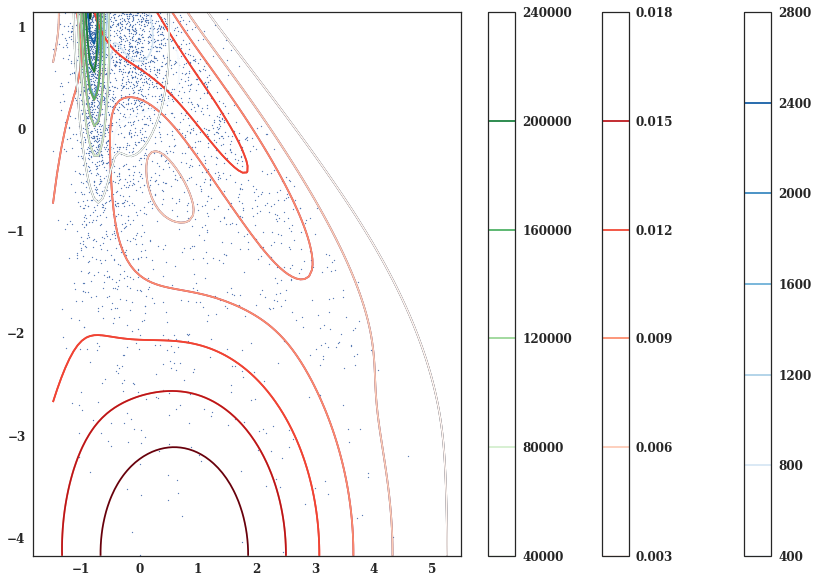

In [34]:
field=1.0
instsf = SF.obsSF[field].SF_model
instdf = SF.obsSF[field].DF_model
plt.figure(figsize=(15,10))

plt.scatter(instsf.y_s, instsf.x_s, s=1)
#plt.scatter(instsf.x_s, instsf.y_s, s=0.1)

#instsf.params_f = instsf.unscaleParams(instsf.params_f_scaled)

x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)

#plt.scatter(instsf.params_f_scaled[:,0], instsf.params_f_scaled[:,1], c='g')
#plt.scatter(instsf.params_i[:,0], instsf.params_i[:,1], c='r')

all_pars = StatisticalModels.gmm_product_p(instsf.params_f_scaled, instsf.params_df)
all_pars = all_pars.reshape(-1, all_pars.shape[-1])
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz, cmap='Blues')
plt.colorbar()

all_pars = instsf.params_f_scaled
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds')
plt.colorbar()

all_pars = instsf.params_df
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Greens')
plt.colorbar()


In [ ]:
all_pars = StatisticalModels.gmm_product_p(instsf.params_f_scaled, instsf.params_df)
all_pars = all_pars.reshape(-1, all_pars.shape[-1])
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz, cmap='Blues')
plt.colorbar()

# New histogram plots

In [78]:
import StatisticalModels

In [79]:
nullfmt = NullFormatter()         # no labels
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 80}
legend = {'fontsize': 20}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
matplotlib.rc('axes', labelsize= 20)

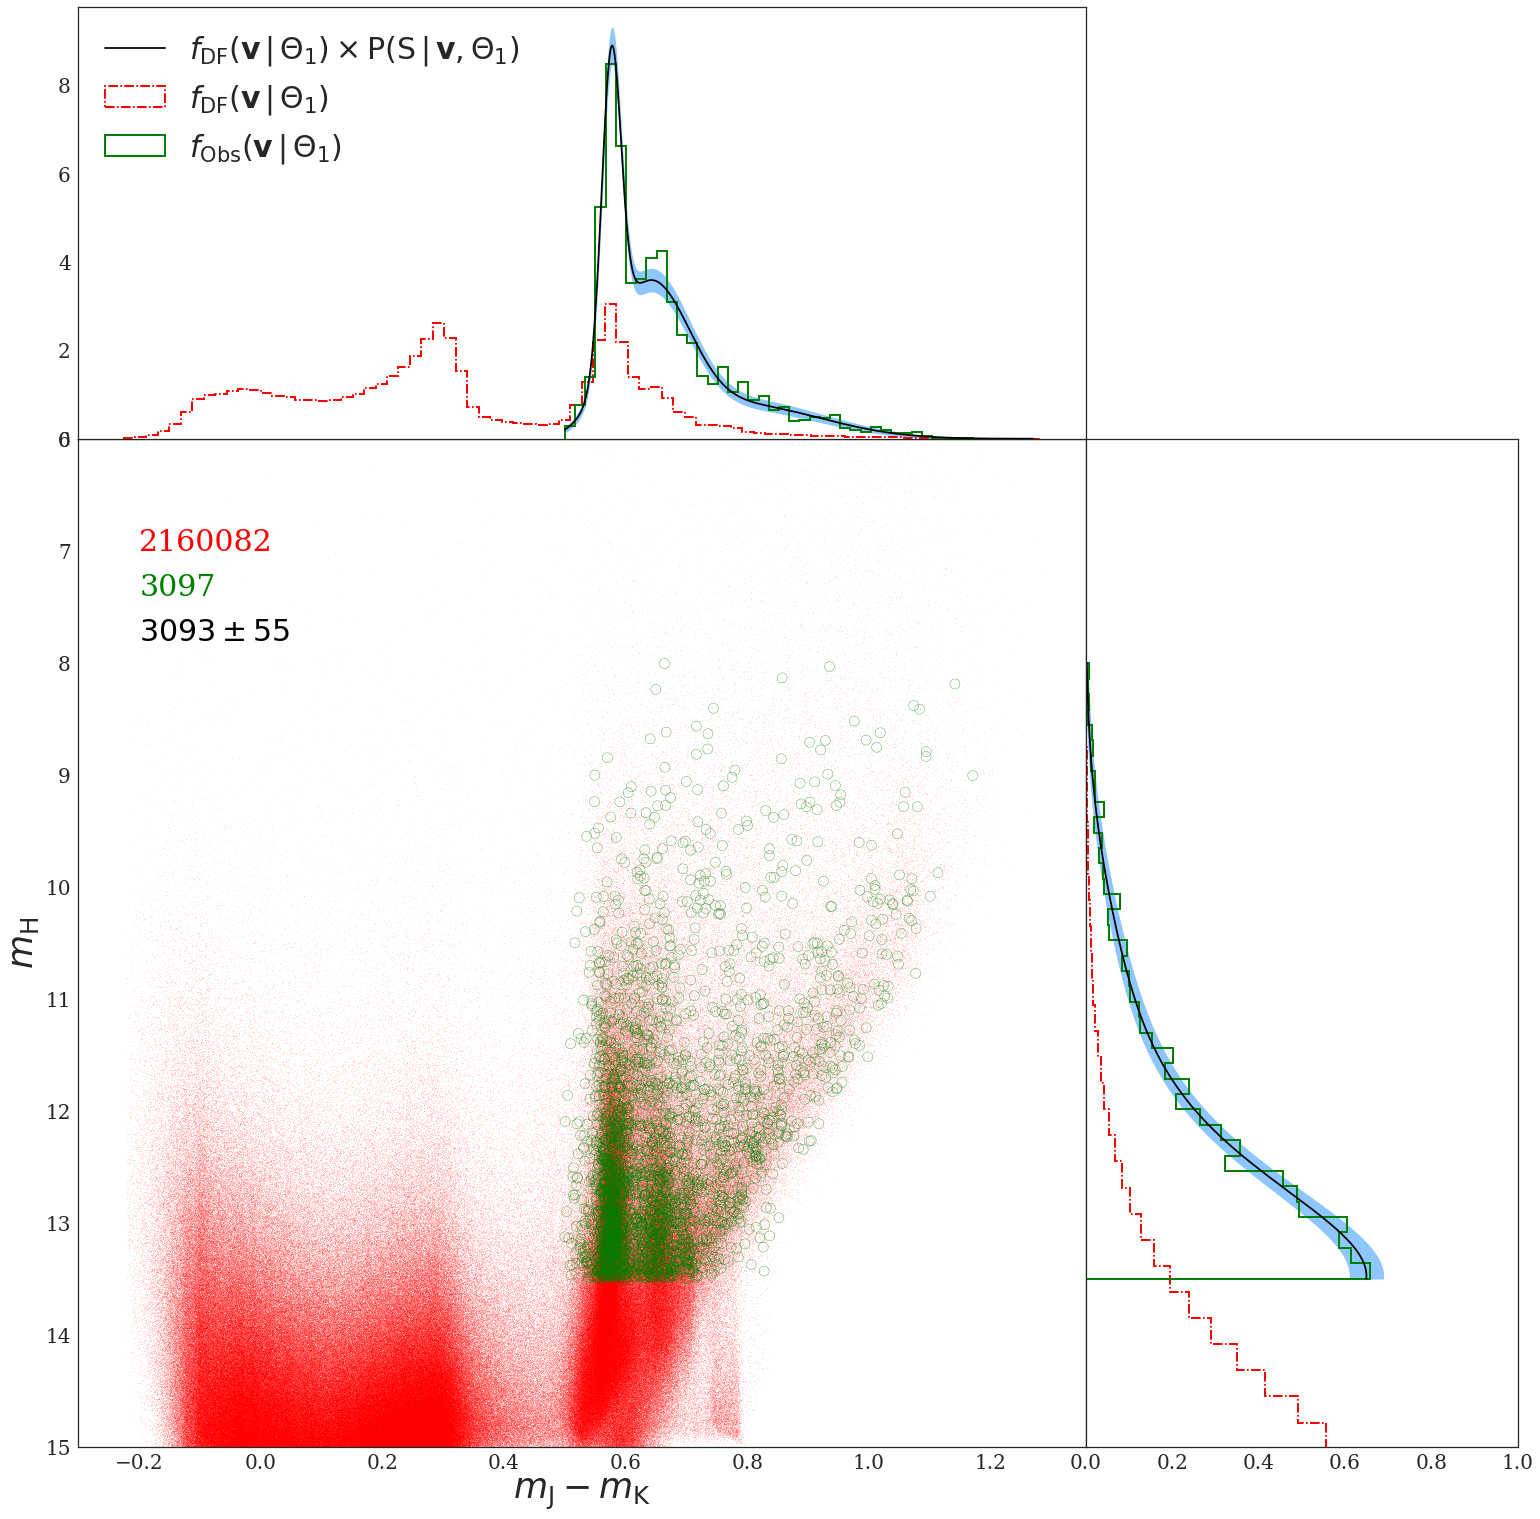

In [246]:
# start with a rectangular Figure
fig=plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (15, 6)

# the scatter plot:
ax_c.scatter(full1.Colour, full1.Happ, s=0.01, c='r', rasterized=True)
ax_c.scatter(survey1.Colour, survey1.Happ, s=100, marker='o', c='none', edgecolors='g', rasterized=True)

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_1)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_1)$'

field=1.0

instsf = SF.obsSF[field].SF_model
instdf = SF.obsSF[field].DF_model
sf_pars = instsf.params_f
obs_pars = StatisticalModels.gmm_product_p(instsf.params_f, instdf.params_f)
obs_pars = obs_pars.reshape(-1, obs_pars.shape[-1])
#norm = np.sum(obs_pars[:,5])
df_pars = instsf.params_df

x = np.linspace(instsf.rngy[0], instsf.rngy[1], 500)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 400)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMix_vect(obs_pars, yy, xx)

z_x = np.sum((zz[:-1,:]+zz[1:,:])*(yy[1:,:]-yy[:-1,:])/2, axis=0)
z_y = np.sum((zz[:,:-1]+zz[:,1:])*(xx[:,1:]-xx[:,:-1])/2, axis=1)
norm = np.sum((z_x[:-1]+z_x[1:])*(x[1:]-x[:-1]))/2

"""
for sample in posterior_samples[:25,...]:
    sample = instsf.unscaleParams(sample)
    pars = StatisticalModels.gmm_product_p(sample, instdf.params_f)
    pars = pars.reshape(-1, pars.shape[-1])
    zz = StatisticalModels.bivGaussMix_vect(pars, yy, xx)
    
    plt.sca(ax_t)
    z_x = np.sum((zz[:-1,:]+zz[1:,:])*(yy[1:,:]-yy[:-1,:])/2, axis=0)
    plt.plot(x, z_x/norm, color='c', alpha=0.5)

    plt.sca(ax_s)
    z_y = np.sum((zz[:,:-1]+zz[:,1:])*(xx[:,1:]-xx[:,:-1])/2, axis=1)
    plt.plot(z_y/norm, y, color='c', alpha=0.5)"""

plt.sca(ax_t)
spec_bins = 40
_=plt.hist(full1.Colour, label=label1, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=80, normed=True)
_=plt.hist(survey1.Colour, label=label2, color='g', linestyle='-', linewidth=2, 
           histtype='step', bins=spec_bins, normed=True)
bin_width = _[1][1]-_[1][0]
z_x = np.sum((zz[:-1,:]+zz[1:,:])*(yy[1:,:]-yy[:-1,:])/2, axis=0)
plt.plot(x, z_x/norm, color='k', label=label3)
#plt.fill_between(x, (z_x-np.sqrt(z_x))/norm, (z_x+np.sqrt(z_x))/norm, color='b', alpha=0.5)
plt.fill_between(x, z_x*(1 - 1/np.sqrt(z_x*bin_width))/norm,  
                  z_x*(1 + 1/np.sqrt(z_x*bin_width))/norm, color='dodgerblue', alpha=0.5)
plt.legend(fontsize=30)

plt.sca(ax_s)
_=plt.hist(full1.Happ, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=80, normed=True, orientation='horizontal')
_=plt.hist(survey1.Happ, color='g', linestyle='-', linewidth=2, 
           histtype='step', bins=40, normed=True, orientation='horizontal')
bin_width = _[1][1]-_[1][0]
z_y = np.sum((zz[:,:-1]+zz[:,1:])*(xx[:,1:]-xx[:,:-1])/2, axis=1)
# Shaded region for poisson noise
plt.fill_betweenx(y, z_y*(1 - 1/np.sqrt(z_y*bin_width))/norm,  
                  z_y*(1 + 1/np.sqrt(z_y*bin_width))/norm, color='dodgerblue', alpha=0.5)
plt.plot(z_y/norm, y, color='k')
plt.xlim(0,1)


    
    
ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())
ax_t.set_ylim(0, ax_t.get_ylim()[1])
ax_s.set_xlim(0, ax_s.get_xlim()[1])

plt.sca(ax_c)
textfont = {'fontsize':30}
plt.text(-0.2, 7., str(len(full1)), color='r', fontdict=textfont)
plt.text(-0.2, 7.4, str(len(survey1)), color='g', fontdict=textfont)
plt.text(-0.2, 7.8, r'$%d \pm %d$' % (norm, np.sqrt(norm)), color='k', fontdict=textfont)

ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', left='off', labelleft='off', labelsize=20)
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', labelsize=20)

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$m_\mathrm{H}$', fontsize=35)

#plt.setp(ax_t.get_legend().get_texts(), fontsize='30') 

plt.show()

fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/G3_colmag_hist_joint1.png', bbox_inches='tight')
fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/G3_colmag_hist_joint1.pdf', bbox_inches='tight')

In [223]:
df_rand = pd.DataFrame()
for i in range(100):
    df_rand = pd.concat((df_rand, full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()))

In [219]:
df_rand = full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()

In [224]:
len(df_rand)

55454

In [77]:
np.sum(full23.union_f>np.random.rand(len(full23)))

1596

In [ ]:
plt.sca(ax_t)
_=plt.hist(full23.Colour, label=label1, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=phot_bins, normed=True)
values, edges = np.histogram(df_rand.Colour, bins=spec_bins, range=instsf.rngy)
values /= n_sample
norm = np.sum(values)*(edges[1]-edges[0])
fill_between_steps(edges, (values-np.sqrt(values))/norm, (values+np.sqrt(values))/norm, 
                   color='dodgerblue', alpha=0.3)
_=plt.hist(survey23.Colour, label=label2, color='g', linestyle='-', linewidth=3, 
           histtype='step', bins=spec_bins, normed=True, range=instsf.rngy)
_=plt.hist(df_rand.Colour, label=label3, color='k', linestyle='--', linewidth=2, 
           histtype='step', bins=spec_bins, normed=True, range=instsf.rngy)
plt.legend(fontsize=30, loc='upper left')

((40,), (40,))
((40,), (40,))


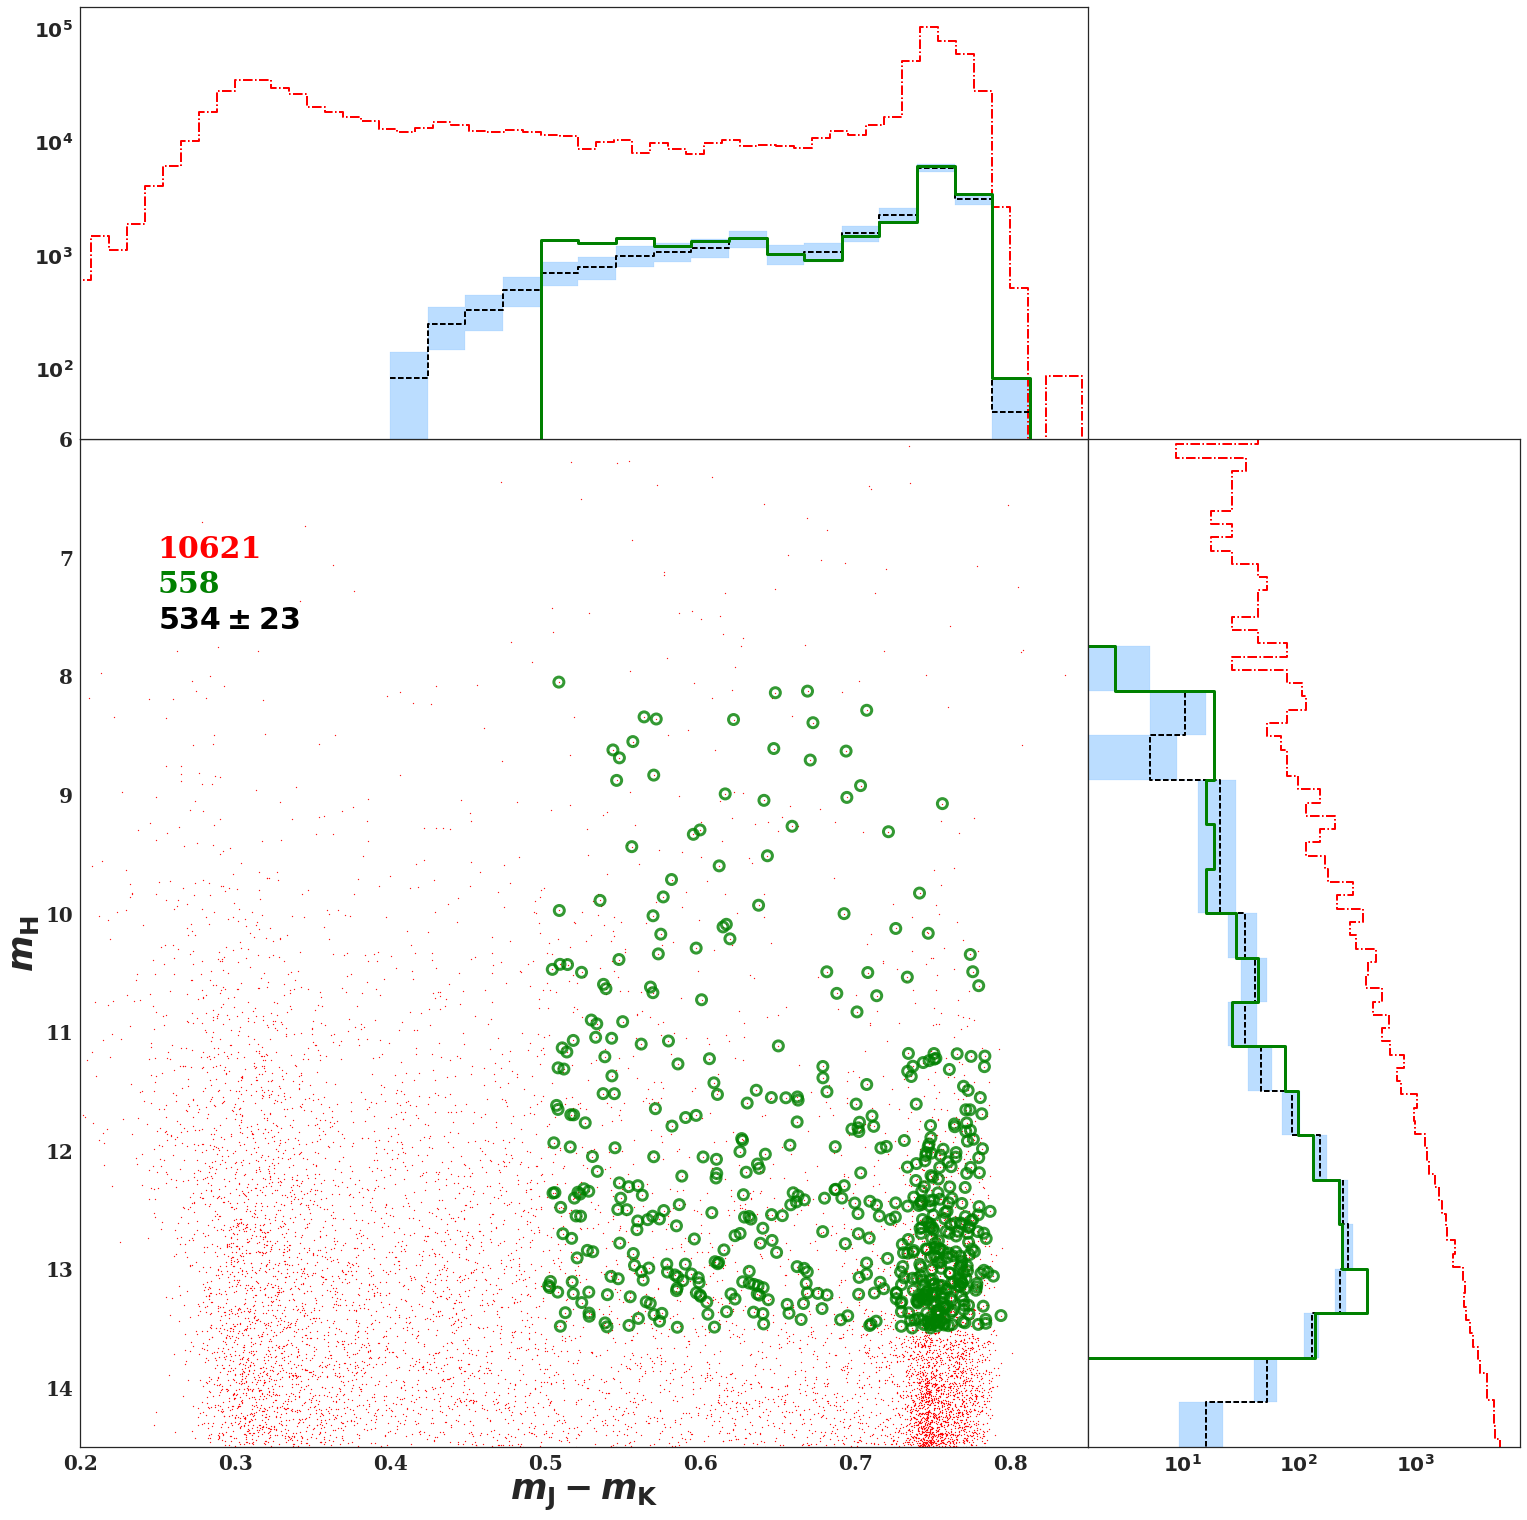

In [297]:
# start with a rectangular Figure
fig = plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

xlim = (0.2, .85)
ylim = (14.5, 6)

# the scatter plot:
ax_c.scatter(full23.Colour, full23.Happ, s=1., c='r', rasterized=True)
ax_c.scatter(survey23.Colour, survey23.Happ, s=100, marker='o', alpha=0.8,
             c='none', edgecolors='g', linewidth=3, rasterized=True)

ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)


label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_2 \cup \Theta_3)$'


field=2.0
instsf = SF.obsSF[field].SF_model
spec_bins = 20
phot_bins = 100

n_sample = 50
df_rand = pd.DataFrame()
for i in range(n_sample):
    df_rand = pd.concat((df_rand, full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()))



# Colour Histogram
plt.sca(ax_t)
# Full sample
phot_hist, edges = np.histogram(full23.Colour, bins=phot_bins)
plot_hist(edges, phot_hist/(edges[1:]-edges[:-1]), horizontal=False, 
          color='r', linestyle='-.', linewidth=2)
# SF weighted sample
values, edges = np.histogram(df_rand.Colour, bins=spec_bins, range=instsf.rngy)
values /= n_sample
fill_between_steps(edges, (values-np.sqrt(values))/(edges[1:]-edges[:-1]), 
                          (values+np.sqrt(values))/(edges[1:]-edges[:-1]), horizontal=False,
                   color='dodgerblue', alpha=0.3)
plot_hist(edges, values/(edges[1:]-edges[:-1]), horizontal=False,
          linestyle='--', color='k', linewidth=2)
# Obs Sample
obs_hist, edges = np.histogram(survey23.Colour, bins=spec_bins, range=instsf.rngy)
plot_hist(edges, obs_hist/(edges[1:]-edges[:-1]), horizontal=False, 
          color='g', linestyle='-', linewidth=3)
plt.yscale('log')


# Magnitude Histogram
plt.sca(ax_s)
# Full sample
phot_hist, edges = np.histogram(full23.Happ, bins=phot_bins)
plot_hist(edges, phot_hist/(edges[1:]-edges[:-1]), horizontal=True, 
          color='r', linestyle='-.', linewidth=2)
# SF weighted sample
values, edges = np.histogram(df_rand.Happ, bins=spec_bins, range=instsf.rngx)
values /= n_sample
fill_between_steps(edges, (values-np.sqrt(values))/(edges[1:]-edges[:-1]), 
                          (values+np.sqrt(values))/(edges[1:]-edges[:-1]), horizontal=True,
                   color='dodgerblue', alpha=0.3)
plot_hist(edges, values/(edges[1:]-edges[:-1]), horizontal=True,
          linestyle='--', color='k', linewidth=2)
# Obs Sample
obs_hist, edges = np.histogram(survey23.Happ, bins=spec_bins, range=instsf.rngx)
plot_hist(edges, obs_hist/(edges[1:]-edges[:-1]), horizontal=True, 
          color='g', linestyle='-', linewidth=3)
plt.xscale('log')



ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())
ax_t.set_ylim(0, ax_t.get_ylim()[1])
ax_s.set_xlim(0, ax_s.get_xlim()[1])

plt.sca(ax_c)
textfont = {'fontsize':30}
plt.text(0.25, 7., str(len(full23)), color='r', fontdict=textfont)
plt.text(0.25, 7.3, str(len(survey23)), color='g', fontdict=textfont)
plt.text(0.25, 7.6, r'$%d \pm %d$' % (np.sum(values), np.sqrt(np.sum(values))), color='k', fontdict=textfont)

ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', left='off', labelleft='off', labelsize=20)
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', labelsize=20)

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$m_\mathrm{H}$', fontsize=35)

#plt.setp(ax_t.get_legend().get_texts(), fontsize='30') 

plt.show()

#fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/G3_colmag_hist_joint23.png', bbox_inches='tight')
#fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/G3_colmag_hist_joint23.pdf', bbox_inches='tight', dpi=200)

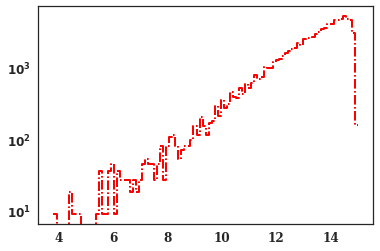

In [94]:
# Full sample
phot_hist, edges = np.histogram(full23.Happ, bins=phot_bins)
plot_hist(edges, phot_hist/(edges[1:]-edges[:-1]), horizontal=False, 
          color='r', linestyle='-.', linewidth=2)
plt.yscale('log')

In [93]:
edges

array([ 7.   ,  7.075,  7.15 ,  7.225,  7.3  ,  7.375,  7.45 ,  7.525,
        7.6  ,  7.675,  7.75 ,  7.825,  7.9  ,  7.975,  8.05 ,  8.125,
        8.2  ,  8.275,  8.35 ,  8.425,  8.5  ,  8.575,  8.65 ,  8.725,
        8.8  ,  8.875,  8.95 ,  9.025,  9.1  ,  9.175,  9.25 ,  9.325,
        9.4  ,  9.475,  9.55 ,  9.625,  9.7  ,  9.775,  9.85 ,  9.925,
       10.   , 10.075, 10.15 , 10.225, 10.3  , 10.375, 10.45 , 10.525,
       10.6  , 10.675, 10.75 , 10.825, 10.9  , 10.975, 11.05 , 11.125,
       11.2  , 11.275, 11.35 , 11.425, 11.5  , 11.575, 11.65 , 11.725,
       11.8  , 11.875, 11.95 , 12.025, 12.1  , 12.175, 12.25 , 12.325,
       12.4  , 12.475, 12.55 , 12.625, 12.7  , 12.775, 12.85 , 12.925,
       13.   , 13.075, 13.15 , 13.225, 13.3  , 13.375, 13.45 , 13.525,
       13.6  , 13.675, 13.75 , 13.825, 13.9  , 13.975, 14.05 , 14.125,
       14.2  , 14.275, 14.35 , 14.425, 14.5  ])

In [44]:
def fill_between_steps(x, y1, y2=0, ax=None, horizontal=False, log=False, **kwargs):
    ''' Fills a hole in matplotlib: fill_between for step plots.
    Parameters :
    ------------
    x : array-like
        Bin edges
    y1 : array-like
        Bin min values
    y2 : array-Like
        Bin max values
    **kwargs will be passed to the matplotlib fill_between() function.
    '''
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:-1]

    # Also, duplicate each y coordinate in both arrays
    y1 = y1.repeat(2)#[:-1]
    if type(y2) == np.ndarray:
        y2 = y2.repeat(2)#[:-1]
        
    print(xx.shape, y1.shape)#, y2.shape)

    # now to the plotting part:
    if not horizontal: ax.fill_between(xx, y1, y2, **kwargs)
    else: ax.fill_betweenx(xx, y1, y2, **kwargs)

    return ax

In [45]:
def plot_hist(x, y, ax=None, horizontal=False, **kwargs):
    ''' Fills a hole in matplotlib: fill_between for step plots.
    Parameters :
    ------------
    x : array-like
        Bin edges
    y : array-like
        Bin values
    **kwargs will be passed to the matplotlib fill_between() function.
    '''
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:-1]

    # Also, duplicate each y coordinate in both arrays
    y = y.repeat(2)

    # now to the plotting part:
    if not horizontal: ax.plot(xx, y, **kwargs)
    else: ax.plot(y, xx, **kwargs)

    return ax

In [191]:
# First, duplicate the x values
xx = x.repeat(2)[1:]
# Now: the average x binwidth
xstep = np.repeat((x[1:] - x[:-1]), 2)
xstep = np.concatenate(([xstep[0]], xstep, [xstep[-1]]))
# Now: add one step at end of row.
xx = np.append(xx, xx.max() + xstep[-1])

In [144]:
plt.legend?

In [ ]:
nullfmt = NullFormatter()         # no labels
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 80}
legend = {'fontsize': 20}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
matplotlib.rc('axes', labelsize= 20)

# start with a rectangular Figure
plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (15, 6)

# the scatter plot:
ax_c.scatter(full23.Colour, full23.Happ, s=0.1, c='r')
ax_c.scatter(survey23.Colour, survey23.Happ, s=100, marker='o', c='none', edgecolors='g')

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_2 \cup \Theta_3)$'

plt.sca(ax_t)
sns.kdeplot(full23.Colour, label=label1, alpha=1., c='r', legend=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey23.Colour, label=label2, alpha=1., c='g', legend=True, linestyle='-', linewidth=2)

plt.sca(ax_s)
sns.kdeplot(full23.Happ, alpha=1., c='r', legend=False, vertical=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey23.Happ, alpha=1., c='g', legend=False, vertical=True, linestyle='-', linewidth=2)

    
df_rand = full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()
kwargs = {'alpha':1., 'color':'k'}
plt.sca(ax_s)
sns.kdeplot(df_rand.Happ, legend=False, vertical=True, linestyle='--', linewidth=2, zorder=2, **kwargs)
plt.sca(ax_t)
sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, label=label3, legend=True, zorder=2, **kwargs)
N=Ns
nrand = np.zeros(Ns)
for i in range(N):
    df_rand = full23[np.random.rand(len(full23)) < full23['union_%d' %i]][['Colour', 'Happ']].copy()

    kwargs = {'alpha':0.2, 'color':'c'}
    if i==0: labelargs = {'label':'Model uncertainty', 'legend':True}
    else: labelargs = {'legend':False}

    plt.sca(ax_s)
    sns.kdeplot(df_rand.Happ, legend=False, vertical=True, linestyle='--', linewidth=2, **kwargs)

    plt.sca(ax_t)
    kwargs.update(labelargs)
    sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, **kwargs)
    nrand[i] = len(df_rand)
    
    
ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())


plt.sca(ax_c)
textfont = {'fontsize':30}
plt.text(0., 7., str(len(full23)), color='r', fontdict=textfont)
plt.text(0., 7.3, str(len(survey23)), color='g', fontdict=textfont)
plt.text(0., 7.6, r'$%d \pm %d$' % (np.mean(nrand), np.std(nrand)), color='c', fontdict=textfont)


ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$m_\mathrm{H}$', fontsize=35)

plt.setp(ax_t.get_legend().get_texts(), fontsize='30') 

plt.show()

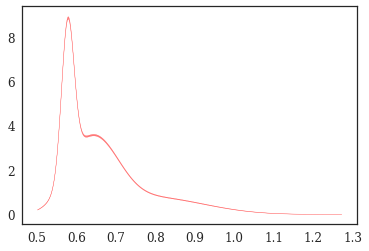

In [81]:
plt.fill_between(x, (z_x-np.sqrt(z_x))/norm, (z_x+np.sqrt(z_x))/norm, color='r', alpha=0.5)

In [84]:
np.sqrt(z_x)/z_x

array([0.03988827, 0.03858209, 0.0373326 , 0.03613663, 0.03499107,
       0.03389279, 0.03283865, 0.03182542, 0.03084974, 0.0299081 ,
       0.02899677, 0.02811179, 0.02724893, 0.02640374, 0.02557155,
       0.02474762, 0.02392723, 0.02310594, 0.02227985, 0.02144593,
       0.02060231, 0.01974865, 0.01888624, 0.01801816, 0.01714911,
       0.01628508, 0.01543299, 0.01460007, 0.01379335, 0.01301919,
       0.01228295, 0.01158873, 0.01093937, 0.01033648, 0.00978057,
       0.00927125, 0.00880745, 0.00838755, 0.00800964, 0.00767158,
       0.00737119, 0.00710629, 0.0068748 , 0.00667476, 0.00650438,
       0.00636204, 0.00624632, 0.00615595, 0.00608987, 0.00604717,
       0.0060271 , 0.00602901, 0.00605239, 0.00609676, 0.0061617 ,
       0.00624677, 0.00635146, 0.00647513, 0.00661697, 0.00677585,
       0.00695035, 0.00713858, 0.00733822, 0.00754642, 0.00775986,
       0.0079748 , 0.0081872 , 0.00839295, 0.00858806, 0.00876898,
       0.00893277, 0.00907733, 0.00920152, 0.00930512, 0.00938

In [72]:
z_x = np.sum((zz[:-1,:]+zz[1:,:])*(yy[1:,:]-yy[:-1,:])/2, axis=0)
z_ = np.sum((z_x[:-1]+z_x[1:])*(x[1:]-x[:-1]))/2
z_

3093.5788313467215

In [78]:
z_y = np.sum((zz[:,:-1]+zz[:,1:])*(xx[:,1:]-xx[:,:-1])/2, axis=1)
z_ = np.sum((z_y[:-1]+z_y[1:])*(y[1:]-y[:-1]))/2
z_

3093.578831346722

In [79]:
norm

4877.9349401083255

In [71]:
z_

3093.5788313467215

In [57]:
(xx[1:,:]-xx[:-1,:])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

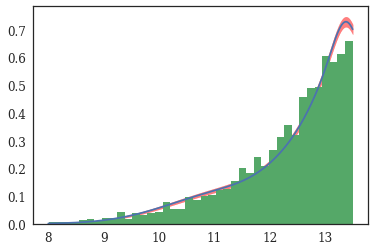

In [162]:
norm = np.sum(obs_pars[:,5])/2.2
plt.fill_between(y, (z_y - np.sqrt(z_y))/norm, (z_y + np.sqrt(z_y))/norm, color='r', alpha=0.5)
plt.plot(y, z_y/norm)

#bin_n, bin_edges =  np.histogram(survey1.Happ, bins=100)
#plt.bar(bin_edges[:-1], bin_n/(norm*(bin_edges[1]-bin_edges[0])), width=bin_edges[1]-bin_edges[0], fill=False)
_=plt.hist(survey1.Happ, bins=40, normed=True)

In [145]:
plt.bar?

In [144]:
len(bin_n), len(bin_edges)

(100, 101)

In [37]:
plt.hist?

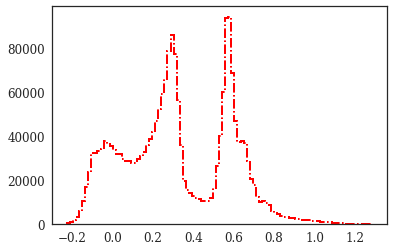

In [33]:
_=plt.hist(full1.Colour, label=label1, color='r', linestyle='-.', linewidth=2, histtype='step', bins=100)

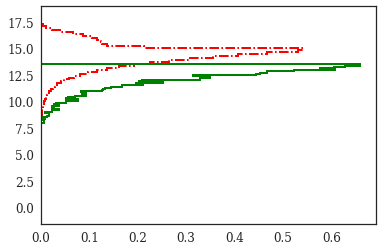

In [38]:
_=plt.hist(full1.Happ, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=100, normed=True, orientation='horizontal')
_=plt.hist(survey1.Happ, color='g', linestyle='-', linewidth=2, 
           histtype='step', bins=50, normed=True, orientation='horizontal')